In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)

import json
import gzip
from joblib import Parallel, delayed
df = pd.read_csv('USPTO_50k.csv')
display(df.head())
print(len(df))

,id,class,reactions
0,US05849732,6,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...
1,US20120114765A1,2,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...
2,US08003648B2,1,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...
3,US09045475B2,1,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...
4,US08188098B2,2,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...


50016


# **1. Load data**

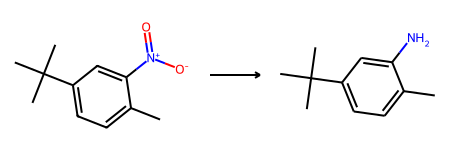

In [2]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions
rxn = rdChemReactions.ReactionFromSmarts(df['reactions'][51], useSmiles=True)
rxn

In [3]:
c

NameError: name 'c' is not defined

In [4]:
split_smiles = df['reactions'].str.split('>>', expand=True)
df['reactants'] = split_smiles[0]
df['products'] = split_smiles[1]

In [5]:
def can_parse(rsmi):
    react, prod = rsmi.split('>>')
    if Chem.MolFromSmiles(prod) and Chem.MolFromSmiles(react):
        return True
    else:
        return False

In [6]:
parsable = Parallel(n_jobs=-1, verbose=1)(delayed(can_parse)(rsmi) for rsmi in df['reactions'].values)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 40944 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    2.3s finished


In [7]:
df = df[parsable]
print('{} parsable reactions'.format(len(df)))

50016 parsable reactions


In [8]:
df.to_json('uspto.reactions.json.gz', orient='records', compression='gzip')

with gzip.open('uspto.reactions.json.gz') as f:
    reactions = json.load(f)

In [9]:
reactions

[{'id': 'US05849732',
  'class': 6,
  'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O'},
 {'id': 'US20120114765A1',
  'class': 2,
  'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1'},
 {'id': 'US08003648B2',
  'class': 1,
  'reactions': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1>>CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4C(=O)OC[C@@H]4Cc4ccccc4)c4ccon4)cc3)s2)cc1',
  'reactants': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1',
  '

# **2. Check balance**

In [10]:
df = pd.DataFrame(reactions)

reacts = df['reactants']
prods =df['products']
from collections import defaultdict

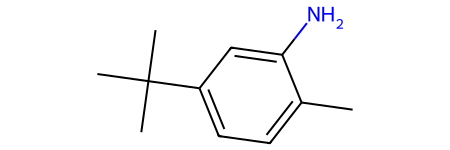

In [11]:
test_prod = Chem.MolFromSmiles(prods[51])
test_prod

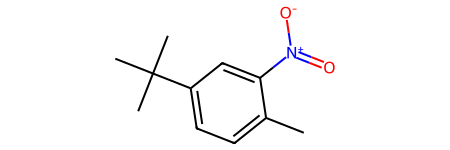

In [12]:
test_reacts = Chem.MolFromSmiles(reacts[51])
test_reacts

## 2.1. Extract composition in molecules

In [13]:
from rdkit.Chem import rdmolops
def composition(smiles):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, fluoride ion (chemical formula F-, SMILES string [F-])
    returns {9: 1, 0: -1}.

    :param molecule: The molecule to analyze
    :type some_input: An RDKit molecule
    :rtype: A dictionary.
    """
    # Check that there is a valid molecule
    molecule = Chem.MolFromSmiles(smiles)
    if molecule:

        # Add hydrogen atoms--RDKit excludes them by default
        molecule_with_Hs = Chem.AddHs(molecule)
        comp = defaultdict(lambda: 0)

        # Get atom counts
        for atom in molecule_with_Hs.GetAtoms():
            comp[atom.GetAtomicNum()] += 1

        # If charged, add charge as "atomic number" 0
        charge = rdmolops.GetFormalCharge(molecule_with_Hs)
        if charge != 0:
            comp[0] = charge
        return dict(sorted(comp.items()))

In [14]:
composition(reacts[22])

{0: -1, 1: 16, 6: 13, 8: 4, 17: 2, 35: 1}

In [15]:
react_dics = Parallel(n_jobs=-1, verbose=1)(delayed(composition)(k) for k in df['reactants'])
prods_dics = Parallel(n_jobs=-1, verbose=1)(delayed(composition)(k) for k in df['products'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 18416 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 28656 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    3.1s finished


In [50]:
prod = prods_dics[51]
react=react_dics[51]

## 2.2. Check if the missing values in reactants or products or the reactions are balance

In [54]:
def check_keys(dict1, dict2):
  return all(key in dict1 for key in dict2)

def compare_dicts(react, prod):
    if not isinstance(react, dict) or not isinstance(prod, dict):
        return "Both inputs must be dictionaries"
    
    if react.keys() != prod.keys():
        if check_keys(react, prod)== True and check_keys(prod, react)==False:
            if all(react[key] >= prod[key] for key in prod.keys()):
                return "Products"
            else:
                return "Both"
        elif check_keys(prod, react)== True and check_keys(react, prod)==False:
            if all(react[key] <= prod[key] for key in react.keys()):
                return "Reactants"
            else:
                return "Both"
        else:
            return "Both"
    else:
        equal = all(react[key] == prod[key] for key in react.keys())
        greater = all(react[key] >= prod[key] for key in react.keys())
        lower = all(react[key] <= prod[key] for key in react.keys())
        if equal:
            return "Balance"
        elif greater:
            return "Products"
        elif lower:
            return "Reactants"
        else:
            return "Both"


In [55]:
compare_dicts(react, prod)


'Both'

In [56]:
unbalance = Parallel(n_jobs=-1, verbose=1)(delayed(compare_dicts)(react_dics[i], prods_dics[i]) for i in range(len(df['products'])))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 43025 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    0.2s finished


In [58]:
np.unique(unbalance, return_counts=True)

(array(['Balance', 'Both', 'Products', 'Reactants'], dtype='<U9'),
 array([ 1076,  3088, 44086,  1766]))

## 2.3. Get the dict difference

In [59]:
def diff_dicts(reacts, prods):
    if not isinstance(reacts, dict) or not isinstance(prods, dict):
        return "Both inputs must be dictionaries"
    
    diff_dict = {}
    
    for key in reacts.keys():
        if key in prods:
            diff_value = abs(reacts[key] - prods[key])
            if diff_value != 0:
                diff_dict[key] = diff_value
        else:
            if reacts[key] != 0:
                diff_dict[key] = reacts[key]
    
    # for unspecific issues when some elements in reactants are greater, and some are lower than the products
    for key in prods.keys():
        if key not in reacts and prods[key] != 0:
            diff_dict[key] = prods[key]
    
    return diff_dict


In [34]:
diff_formula = Parallel(n_jobs=-1, verbose=1)(delayed(diff_dicts)(react_dics[i], prods_dics[i]) for i in range(len(df['products'])))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 47099 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    0.2s finished


In [35]:
diff_formula

[{1: 6, 6: 8, 8: 2},
 {1: 2, 8: 1},
 {8: 1},
 {8: 1},
 {1: 1, 17: 1},
 {1: 2, 5: 1, 8: 2, 35: 1},
 {1: 12, 5: 1, 6: 6, 8: 2, 35: 1},
 {1: 2},
 {1: 2, 8: 1},
 {1: 1, 35: 1},
 {1: 8, 6: 4},
 {1: 8, 6: 8, 8: 1},
 {1: 2, 8: 1},
 {8: 1},
 {1: 1, 35: 1},
 {1: 2, 6: 1},
 {1: 1, 17: 1},
 {1: 1, 9: 1},
 {1: 1, 9: 1},
 {1: 1, 17: 1},
 {1: 6, 6: 7},
 {1: 2, 8: 1},
 {0: -1, 35: 1},
 {1: 1, 35: 1},
 {1: 8, 6: 3, 14: 1},
 {1: 1, 17: 1},
 {},
 {1: 1, 35: 1},
 {1: 2, 8: 1},
 {1: 2, 6: 1},
 {1: 2, 8: 1},
 {},
 {1: 15, 6: 18, 8: 1, 15: 1},
 {1: 1, 17: 1},
 {8: 1},
 {1: 2, 8: 1},
 {1: 1, 35: 1},
 {1: 1, 17: 1},
 {1: 1, 17: 1},
 {8: 1},
 {1: 1, 17: 1},
 {1: 2, 8: 1},
 {1: 1, 17: 1},
 {1: 1, 17: 1},
 {1: 10, 6: 5, 8: 3},
 {1: 1, 17: 1},
 {1: 2, 8: 1},
 {1: 2, 5: 1, 8: 2, 53: 1},
 {1: 1, 17: 1},
 {1: 1, 17: 1},
 {},
 {1: 2, 8: 2},
 {},
 {1: 1, 17: 1},
 {1: 2, 8: 1},
 {1: 6, 6: 2, 8: 1},
 {1: 1, 17: 1},
 {1: 2, 5: 1, 8: 2, 17: 1},
 {1: 1, 17: 1},
 {1: 2, 8: 1},
 {1: 2, 8: 1},
 {1: 5, 6: 4, 7: 1, 8: 2},
 {1: 

In [36]:
unbalance

['Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Reactants',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Balance',
 'Products',
 'Products',
 'Products',
 'Products',
 'Balance',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Balance',
 None,
 'Balance',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Balance',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Products',
 'Reactants',
 'Products',
 'Products',
 None,
 'Products',
 

In [37]:
df['Type Unbalance'] = unbalance
df['Diff dict'] = diff_formula

In [38]:
(df['Type Unbalance'] != 'Balance').sum()

48940

In [46]:
df[df['Type Unbalance'].isnull()]

,id,class,reactions,reactants,products,Type Unbalance,Diff dict
51,US06492393B1,7,Cc1ccc(C(C)(C)C)cc1[N+](=O)[O-]>>Cc1ccc(C(C)(C...,Cc1ccc(C(C)(C)C)cc1[N+](=O)[O-],Cc1ccc(C(C)(C)C)cc1N,None,"{1: 2, 8: 2}"
76,US06329405B1,7,CC(NC(c1ccc(F)cc1)c1cccc([N+](=O)[O-])c1)c1ccc...,CC(NC(c1ccc(F)cc1)c1cccc([N+](=O)[O-])c1)c1ccc...,CC(NC(c1ccc(F)cc1)c1cccc(N)c1)c1ccc(F)c(F)c1,None,"{1: 2, 8: 2}"
206,US05109002,3,O=C(CC1CCN(CC2CC2)CC1)c1ccc(F)cc1.[Mg+]c1ccccc...,O=C(CC1CCN(CC2CC2)CC1)c1ccc(F)cc1.[Mg+]c1ccccc1,OC(CC1CCN(CC2CC2)CC1)(c1ccccc1)c1ccc(F)cc1,None,"{0: 1, 1: 1, 12: 1}"
235,US05107013,9,COc1ccc2cc(C(C)C#N)ccc2c1Br>>COc1ccc2cc(C(C)C#...,COc1ccc2cc(C(C)C#N)ccc2c1Br,COc1ccc2cc(C(C)C#N)ccc2c1,None,"{1: 1, 35: 1}"
294,US05739132,4,CCCCS(=O)(=O)NC1Cc2ccc(-c3ccc(=O)n(CC#N)n3)cc2...,CCCCS(=O)(=O)NC1Cc2ccc(-c3ccc(=O)n(CC#N)n3)cc2...,CCCCS(=O)(=O)NC1Cc2ccc(-c3ccc(=O)n(Cc4nnn[nH]4...,None,"{0: -1, 1: 1}"
...,...,...,...,...,...,...,...
49638,US08263610B2,6,CC(C)(C)OC(=O)N1CCN(C(C(=O)N2CCc3c(cnc4[nH]nc(...,CC(C)(C)OC(=O)N1CCN(C(C(=O)N2CCc3c(cnc4[nH]nc(...,O=C(C(c1ccccc1)N1CC[NH2+]CC1)N1CCc2c(cnc3[nH]n...,None,"{1: 7, 6: 5, 8: 2, 0: 1}"
49716,US20150210697A1,7,O=[N+]([O-])c1cc(Br)c(F)c(Br)c1>>Nc1cc(Br)c(F)...,O=[N+]([O-])c1cc(Br)c(F)c(Br)c1,Nc1cc(Br)c(F)c(Br)c1,None,"{1: 2, 8: 2}"
49893,US05599832,9,Cn1c(I)cc2cc(Cl)ccc21>>Cn1ccc2cc(Cl)ccc21,Cn1c(I)cc2cc(Cl)ccc21,Cn1ccc2cc(Cl)ccc21,None,"{1: 1, 53: 1}"
50008,US06265432B1,9,O=C(O)CCC(=NO)c1ccc(-c2ccc(Cl)cc2)c(F)c1>>O=C(...,O=C(O)CCC(=NO)c1ccc(-c2ccc(Cl)cc2)c(F)c1,O=C(O)CCC(=NO)c1ccc(-c2ccccc2)c(F)c1,None,"{1: 1, 17: 1}"


In [39]:
df[df['Type Unbalance'] != 'Balance'].index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            50006, 50007, 50008, 50009, 50010, 50011, 50012, 50013, 50014,
            50015],
           dtype='int64', length=48940)

In [220]:
(df['Type Unbalance'] =='Products').sum()

24092

## 2.4 Analyze missing atoms for "Greater" and "Lower"

In [221]:
df[df['Type Unbalance'] !='Balance'].shape

(48940, 7)

In [222]:
test = df[df['Type Unbalance'] !='Balance']['Diff dict']
test = pd.DataFrame(test.tolist())
test.shape

(48940, 17)

In [223]:
df_test = pd.DataFrame()
df_test['Total missing atoms'] = test.drop(columns=[0]).sum(axis=1)
df_test['Number of atomic missing'] = test.drop(columns=[0]).notnull().sum(axis=1)
#df_test['Type'] = df[df['Type Unbalance'] !='Balance']['Type Unbalance']

In [224]:
test['Total missing atoms'] = df_test['Total missing atoms']
test['Number of atomic missing'] = df_test['Number of atomic missing']
test['Type'] = df[df['Type Unbalance'] !='Balance']['Type Unbalance']
test.index = df[df['Type Unbalance'] !='Balance'].index

<Axes: >

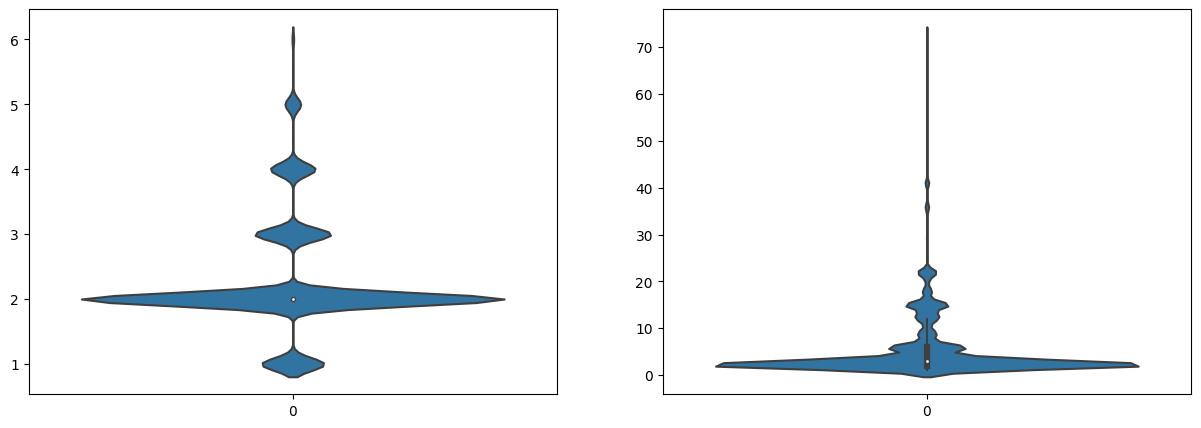

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.violinplot(data=test['Number of atomic missing'])
plt.subplot(1,2,2)
sns.violinplot(data=test['Total missing atoms'])

## 2.4.1. 1 missing atoms

In [226]:
test

,1,6,8,17,5,35,9,0,14,15,53,7,16,50,12,29,30,Total missing atoms,Number of atomic missing,Type
0,6.0,8.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,3,Products
1,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2,Products
2,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,Products
3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,Products
4,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2,Both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50011,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,Products
50012,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,2,Both
50013,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2,Products
50014,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2,Both


In [227]:
test1 = test[test.loc[:,'Number of atomic missing']<2]
test1.shape

(4922, 20)

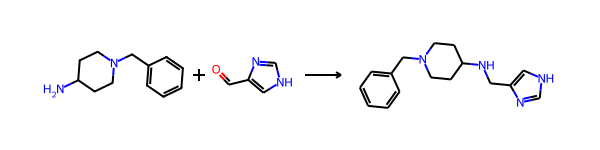

In [228]:
rdChemReactions.ReactionFromSmarts(df['reactions'][13], useSmiles=True)

In [231]:
diff_formula[13]

{8: 1}

In [230]:
test1.drop_duplicates()

,1,6,8,17,5,35,9,0,14,15,53,7,16,50,12,29,30,Total missing atoms,Number of atomic missing,Type
2,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,Products
7,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,Reactants
13,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,Both
22,NaN,NaN,NaN,NaN,NaN,1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,Both
73,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,Both
162,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,Products
244,NaN,NaN,NaN,NaN,NaN,1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,Products
279,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1,Products
294,1.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,Products
297,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1,Both


In [48]:
diff_formula[268]

{1: 2, 8: 1}

## 2.4.2. 2 missing atoms

In [160]:
test2 = test[(test['Number of atomic missing']<3)&(test['Number of atomic missing']>1)]
test2.shape

(0, 12)

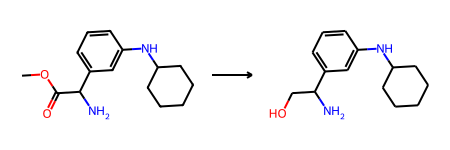

In [87]:
rxn = rdChemReactions.ReactionFromSmarts(df['reactions'][82], useSmiles=True)
rxn

In [84]:
test2.drop_duplicates().sort_values(by='Total missing atoms')

,1,6,8,17,5,35,9,0,14,15,53,7,16,50,12,29,30,Total missing atoms,Number of atomic missing
2443,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,2
27480,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,2
533,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2
495,1.0,NaN,1.0,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2
397,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2
390,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,2
4401,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2
10998,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2
206,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,2
1000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,2


## 2.4.3. 3 missing atoms

In [163]:
test3 = test[(test['Number of atomic missing']<4)&(test['Number of atomic missing']>2)]
test3.shape

(3866, 12)

In [164]:
test3.drop_duplicates()

,1,6,8,35,9,17,7,53,16,14,Total missing atoms,Number of atomic missing
2,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3
7,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3
279,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,3
1164,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,5.0,3
1499,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3
2070,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,3
10326,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3


## 2.5 List of compounds

In [ ]:
smi = [[]]